In [1]:
import torch
from torch import nn

In [3]:
torch. __version__

'1.13.1+cu116'

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import torchinfo

# Get data

In [8]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


#Data preparation

In [16]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [17]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [18]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Visualize

Random image path: data/pizza_steak_sushi/test/steak/1285886.jpg
image class: steak
image height : 512
image width: 512


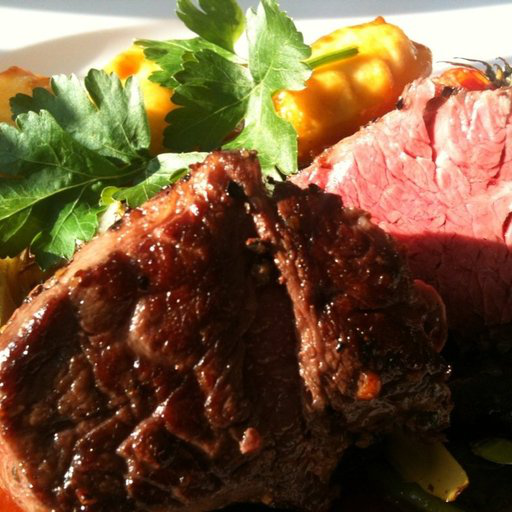

In [25]:
import random
from PIL import Image

random.seed(42)
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 해당 경로에서 랜덤하게 1개 사진 선택 
random_image_path = random.choice(image_path_list)

# 해당 사진의 class가 parent 위치에 있기 때문에 class에 호출 
image_class = random_image_path.parent.stem

# PIL에서 image.open 사용해서 사진 열기 
img = Image.open(random_image_path)

print(f'Random image path: {random_image_path}')
print(f'image class: {image_class}')
print(f'image height : {img.height}')
print(f'image width: {img.width}')
img

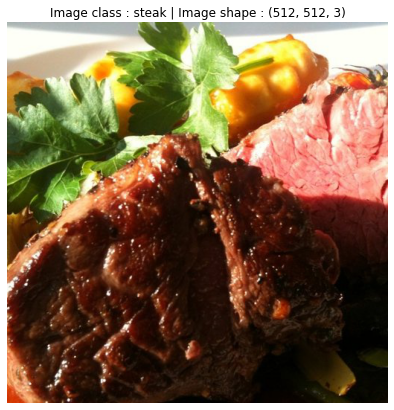

In [27]:
import numpy as np
import matplotlib.pyplot as plt

image_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(image_as_array)
plt.title(f'Image class : {image_class} | Image shape : {image_as_array.shape}')
plt.axis(False);

# Transforming data

In [28]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [29]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
                      transforms.RandomHorizontalFlip(p=0.5),
                      # 정규화는 무조건 마지막에 넣어줄 것 
                      transforms.ToTensor()
])

In [35]:
def plot_transformed_images(image_paths, transform, n=3, seed=42) :
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths :
        with Image.open(image_path) as f :
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original \nSize: {f.size}')
            ax[0].axis('off')

            # pytorch : (C, H, W) > matplotlib : (H, W, C)
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed \n Size: {transformed_image.size}')
            ax[1].axis('off')

            fig.suptitle(f"Class : {image_path.parent.stem}", fontsize=16)
        

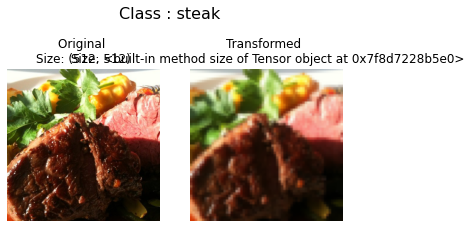

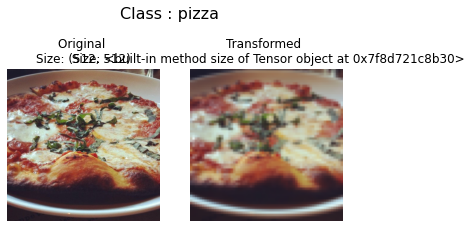

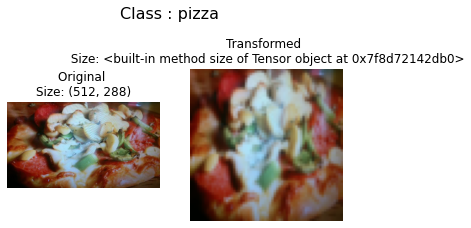

In [38]:
plot_transformed_images(image_path_list, data_transform, n=3)

# Loading image with imagefolder

In [40]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f'Train data : \n {train_data}\nTest data : \n{test_data}')

Train data : 
 Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data : 
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [42]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [43]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [44]:
len(train_data), len(test_data)

(225, 75)

Original shape : torch.Size([3, 64, 64])
Image permute shape : torch.Size([64, 64, 3])


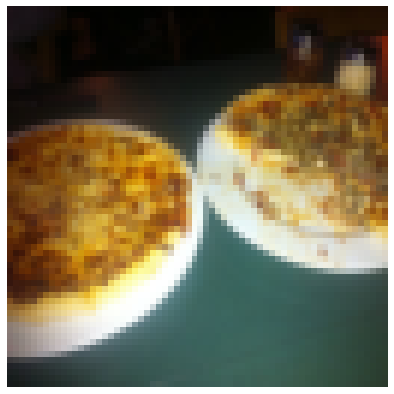

In [47]:
img, label = train_data[0][0], train_data[0][1]

img_permute = img.permute(1, 2, 0)
print(f'Original shape : {img.shape}')
print(f'Image permute shape : {img_permute.shape}')

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False);

## Turn loaded image into dataloader

In [48]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

len(train_dataloader), len(test_dataloader)

(225, 75)

In [49]:
img, label = next(iter(train_dataloader))
print(f'Image shape : {img.shape}')
print(f'Lable shape : {label.shape}')

Image shape : torch.Size([1, 3, 64, 64])
Lable shape : torch.Size([1])


# Loading image with custom dataset

In [51]:
import os
import pathlib
import torchinfo

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [52]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [53]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [54]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [56]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [120]:
from torch.utils.data import Dataset
# 언더바가 붙은 항목들은 반드시 선언해주어야 한다. 

class ImageFolderCustom(Dataset) :
    # init 함수는 생섬함수기 때문에 아무것도 return하지 않는다는 의미 
    def __init__(self, targ_dir : str, transform=None) -> None :
        self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    def load_image(self, index :  int) -> Image.Image :
        'Opens an image via a path and returns it'
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self) -> int :
        'Returns the total number of samples'
        return len(self.paths)

    def __getitem__(self, index : int) -> Tuple[torch.Tensor, int ]:
        'Returns one sample of data, data and label (X, y)'
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        # transform이 입력되면 실행될 조건문 
        if self.transform :
            return self.transform(img), class_idx
        else :
            return img, class_idx 

In [121]:
from torchvision.transforms.transforms import RandomHorizontalFlip
train_transforms = transforms.Compose([
    transforms.Resize((64 ,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [122]:
# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [123]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f8d71f4a5e0>,
 <__main__.ImageFolderCustom at 0x7f8d71f4adf0>)

In [124]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [125]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [126]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [127]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


# Create a function to display random images

In [128]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                            classes: List[str] = None,
                            n: int=10,
                            display_shape : bool=True,
                            seed: int= None) :
    if n> 10 :
        n =10
        display_shape = False

    if seed :
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16, 8))


    for i, targ_sample in enumerate(random_samples_idx) :
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off') 
        if classes :
            title = f'class: {classes[targ_label]}'
            if display_shape :
                title = title + f'\nshape: {targ_image_adjust.shape}' 
            plt.title(title)  

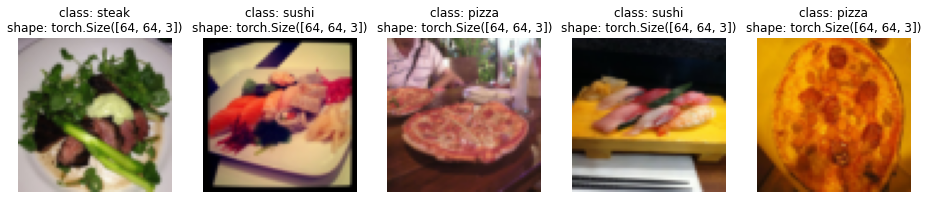

In [129]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

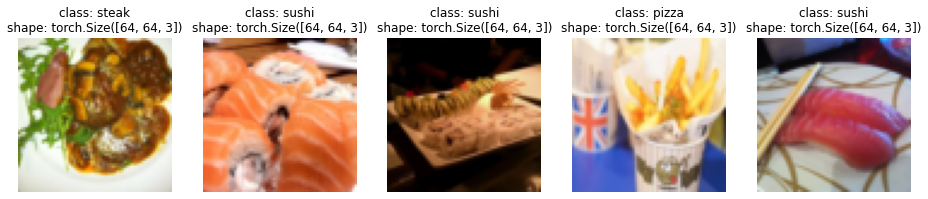

In [130]:

display_random_images(train_data_custom, 
                      n = 5,
                      classes = class_names, 
                      seed=None)

# Data Augmentation

In [131]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

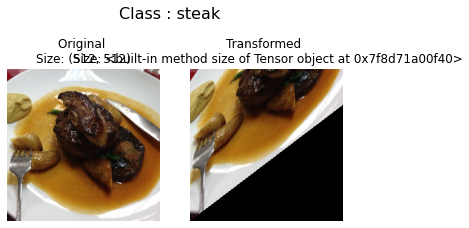

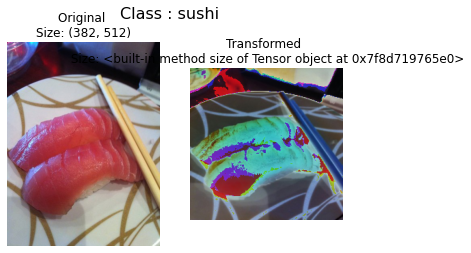

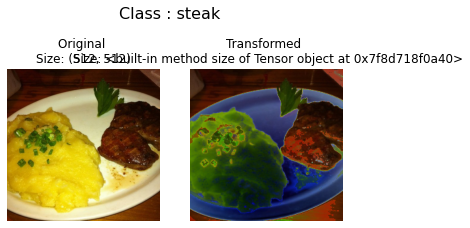

In [132]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

# Modeling
- TinyVGG
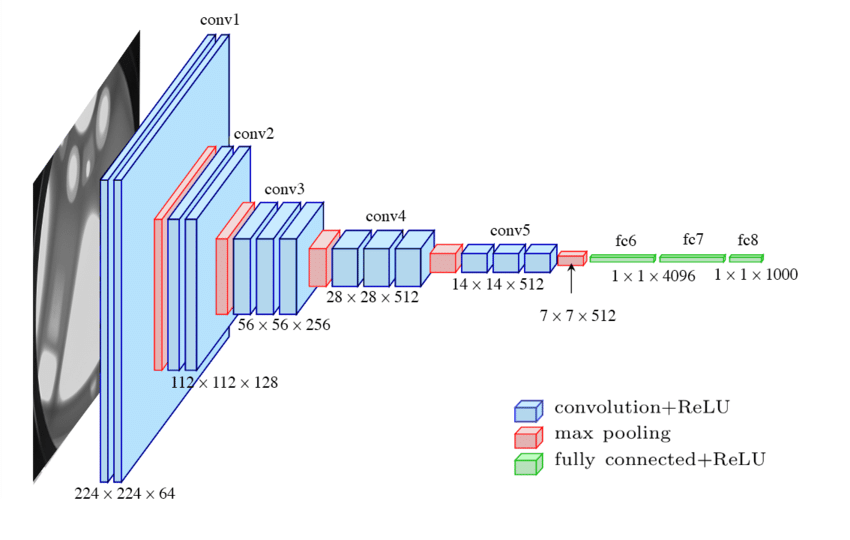

- 깊고 좁은 형태
- 16개의 레이어로 구성되어 있다. 

## Tiny VGG

In [133]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [134]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7f8d718989a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8d7184b7c0>)

In [ ]:
class TinyVGG(nn.Module):

    def __init__(self, input_shape:int, hidden_units:int, output_shape:int) -> None :
        super().__int__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                        out_channels=hidden_units,
                        kernel_size=3,
                        stride=1,
                        padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(h)
        )